In [155]:
%reload_ext autoreload
%autoreload 2

## Imports

In [156]:
import sys

In [157]:
sys.path.append("..")

In [158]:
import pandas as pd

In [159]:
import matplotlib.pyplot as plt

In [160]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

In [161]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

## Folders

In [162]:
DATA_FOLDER = "../data"
# ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

## Main

In [163]:
# Get training ids and validation ids
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [164]:
print("Samples in training set: {}".format(len(train_ids)))
print("Samples in validation set: {}".format(len(val_ids)))

n_samples_total = len(val_ids) + len(train_ids)

print("Total samples: {}".format(n_samples_total))

# Sanity checks: union must be equal to total, intersection must be 0
assert (len(set(val_ids).union(set(train_ids))) == n_samples_total)
assert (len(set(val_ids).intersection(set(train_ids))) == 0)

Samples in training set: 8010
Samples in validation set: 2005
Total samples: 10015


### Plot distributions in sets

In [165]:
data_df = read_meta_data(DATA_FOLDER)

data_train = data_df.loc[train_ids]
data_val = data_df.loc[val_ids]

#### Training set

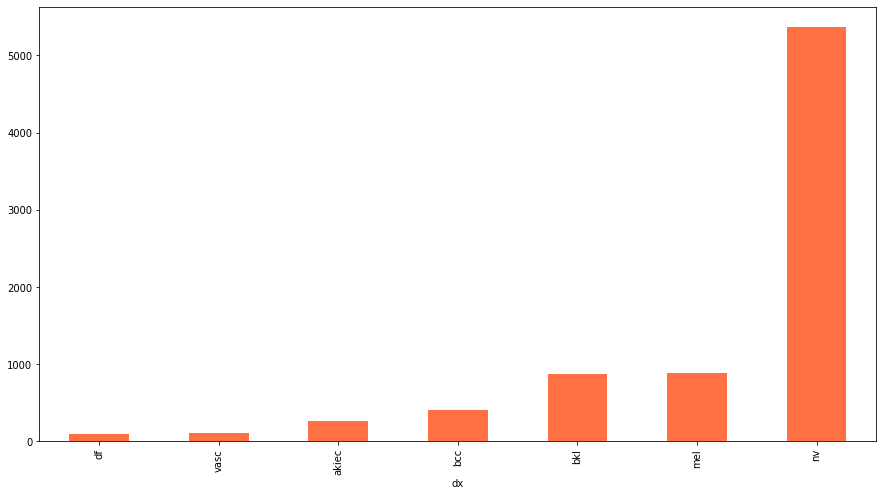

In [166]:
plt.figure(figsize=(15,8))
data_train.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color="#ff7043")

#### Validation set

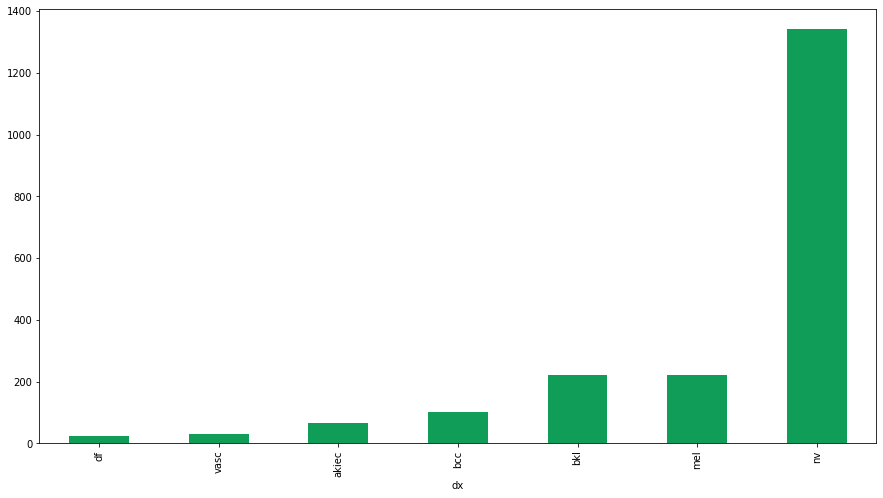

In [167]:
plt.figure(figsize=(15,8))
data_val.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color='#0f9d58')

In [168]:
dataset_train = HAM10000(DATA_FOLDER, train_ids)

In [169]:
data_train

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0031929,HAM_0001499,akiec,histo,65.0,male,lower extremity
ISIC_0030785,HAM_0004609,akiec,histo,75.0,male,back
ISIC_0028816,HAM_0003123,akiec,histo,60.0,male,face
ISIC_0025790,HAM_0001004,akiec,histo,75.0,female,lower extremity
ISIC_0026702,HAM_0005228,akiec,histo,80.0,female,face
...,...,...,...,...,...,...
ISIC_0028885,HAM_0005427,vasc,consensus,75.0,male,back
ISIC_0027856,HAM_0007118,vasc,consensus,45.0,female,trunk
ISIC_0025452,HAM_0004257,vasc,consensus,55.0,female,abdomen


### Data loading

In [170]:
weights = dataset_train.make_weights_for_balanced_classes()

In [171]:
dataset_train._weight_per_class

[30.689655172413794,
 19.48905109489051,
 9.112627986348123,
 87.06521739130434,
 9.0,
 1.4932885906040267,
 70.88495575221239]

In [172]:
BATCH_SIZE = 4

In [173]:
sampler = WeightedRandomSampler(weights, len(weights))

dataloader_train = DataLoader(dataset_train, BATCH_SIZE, sampler=sampler, num_workers=4)

In [174]:
from tqdm import tqdm

In [175]:
i = 0

counts = [0] * 7

SAMPLE_ITERATIONS = 100

for data, target in tqdm(dataloader_train, total=SAMPLE_ITERATIONS):
    if i >= SAMPLE_ITERATIONS:
        break
        
    for c in target:
        counts[c] += 1
    
    i += 1

 96%|█████████▌| 96/100 [00:02<00:00, 43.39it/s]


In [176]:
for i, c in enumerate(dataset_train.get_class_map_dict()):
    print("# of samples for class {}:\t{}".format(c, counts[i]))

# of samples for class akiec:	54
# of samples for class bcc:	46
# of samples for class bkl:	59
# of samples for class df:	73
# of samples for class mel:	60
# of samples for class nv:	52
# of samples for class vasc:	56


In [177]:
# Sanity check on results
assert(sum(counts) == BATCH_SIZE * SAMPLE_ITERATIONS)